In [5]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
from matplotlib.colors import ListedColormap
solvers.options['show_progress']=False

In [50]:
def find_state(row, col, action, shape):
   
    if action == 0:
        row2, col2 = (max(row-1,0), col)
   
    elif action == 1:
        row2, col2 = (row, max(col-1,0))
   
    elif action == 2:
        row2, col2 = (min(row+1, shape[0]-1), col)
   
    elif action == 3:
        row2, col2 = (row, min(col+1, shape[1]-1))
    return (row2, col2)

def get_diff_of_policy(P1, P2,gamma):
    return np.dot((P1-P2), np.linalg.inv(np.identity(P1.shape[0])-gamma*P1))

def find_transition_matrix(policy, num_actions, w):
    
    transition_matrix = np.zeros((len(policy)*len(policy[0]), len(policy)*len(policy[0])))
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            cur_state_index = r + c*policy.shape[0]
            opt_action = policy[r][c]
            for ex in range(num_actions):
                next_r, next_c = find_state(r,c,ex,policy.shape)
                trans_prob = w/4
                if ex == opt_action:
                    trans_prob +=  (1-w)
                next_state_index = next_r + next_c*policy.shape[0]
                transition_matrix[cur_state_index][next_state_index] += trans_prob
                
    return transition_matrix    



def get_D_and_b_matrices(opt_policy, r_max, num_actions, gamma, random_action_prob):
    
    P_a1 = find_transition_matrix(opt_policy, num_actions, random_action_prob)
    P_a2 = find_transition_matrix(np.mod(opt_policy+1,num_actions), num_actions, random_action_prob)
    P_a3 = find_transition_matrix(np.mod(opt_policy+2,num_actions), num_actions, random_action_prob)
    P_a4 = find_transition_matrix(np.mod(opt_policy+3,num_actions), num_actions, random_action_prob)
    
    N = np.ma.size(opt_policy)
    I_NxN = np.identity(N)
    zero_NxN = np.zeros((N,N))
    
    D1 = np.concatenate([I_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a2, gamma)],axis=1)
    D2 = np.concatenate([I_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a3, gamma)],axis=1)
    D3 = np.concatenate([I_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a4, gamma)],axis=1)
    D4 = np.concatenate([zero_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a2, gamma)],axis=1)
    D5 = np.concatenate([zero_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a3, gamma)],axis=1)
    D6 = np.concatenate([zero_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a4, gamma)],axis=1)
    D7 = np.concatenate([zero_NxN, -I_NxN, I_NxN],axis=1)
    D8 = np.concatenate([zero_NxN, -I_NxN, -I_NxN],axis=1)
    D9 = np.concatenate([zero_NxN, zero_NxN, I_NxN],axis=1)
    D10 = np.concatenate([zero_NxN, zero_NxN, -I_NxN],axis=1)
    D = np.concatenate([D1,D2,D3,D4,D5,D6,D7,D8,D9,D10],axis=0)
    
    b = np.concatenate([np.zeros((8*N,)), r_max*np.ones((2*N,))])
    
    return D, b
    
def get_optimal_val(reward, estimation_step, w, gamma):
    
    V = np.zeros(reward.shape)
    P = np.zeros(reward.shape)
    delta = float('inf')
    
    i = 0
    while delta > estimation_step:
        delta = 0

        for r in range(V.shape[0]):
            for c in range(V.shape[1]):

                ideal_action_val = -float('inf')
                
                best_action = 0 
                
                for a in range(4):
                    action_value = 0

                    for ex in range(4):

                        next_r, next_c = find_state(r,c,ex,V.shape)

     
                        execution_probability = (w / 4)

                        if ex == a:
                            execution_probability += (1-w)

                        
                        action_value += (execution_probability) * (reward[next_r,next_c] + gamma*V[next_r,next_c])

                    if action_value > ideal_action_val:
                        ideal_action_val = action_value
                        best_action = a
                        
                #print("Iteration " + str(i))
                #print(ideal_action_val, best_action)
                delta = max(delta, abs(V[r][c] - ideal_action_val))
                V[r][c] = ideal_action_val 
                P[r][c] = best_action
        i = i + 1
        print(delta)
    print(i)
    return V,P

In [27]:
w = 0.1

In [51]:
V, P = get_optimal_val(reward1, estimation_step, w, gamma)

0.9870000000000001
0.7811851999999999
0.6184217780800001
0.48958234650483234
0.3875858692674461
0.30683879727585905
0.24291404617757628
0.1923069530464412
0.15224300447595063
0.12052571187470829
0.0954161885672482
0.07553781594904585
0.06007419835129152
0.047606226982926714
0.037694874937064804
0.029977539650948515
0.023851839484637344
0.018974289470062883
0.015091299225087756
0.01200068146059638
0.009542522841845001
21


In [43]:
P

array([[2., 3., 3., 3., 3., 3., 3., 2., 2., 2.],
       [2., 2., 3., 3., 3., 3., 2., 2., 2., 2.],
       [2., 2., 3., 3., 3., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 3., 2., 2., 2., 2., 2., 2.],
       [2., 2., 3., 3., 3., 2., 2., 2., 2., 2.],
       [2., 3., 3., 3., 3., 3., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 2.]])

In [42]:
V

array([[0.04179568, 0.06283791, 0.089742  , 0.12384898, 0.16708096,
        0.22188288, 0.29135376, 0.37942014, 0.49098293, 0.60964773],
       [0.06283791, 0.08787011, 0.12155728, 0.16451357, 0.21924607,
        0.28898976, 0.37787112, 0.49106061, 0.63321853, 0.78735399],
       [0.089742  , 0.12155728, 0.16438987, 0.21913198, 0.28890328,
        0.37782648, 0.49115592, 0.63549019, 0.81735527, 1.01859718],
       [0.12384898, 0.16451357, 0.21913198, 0.28889981, 0.37782476,
        0.49115916, 0.6356006 , 0.81960951, 1.05219113, 1.31505855],
       [0.16708096, 0.21924607, 0.28890328, 0.37782476, 0.49115918,
        0.63560325, 0.81969511, 1.05426506, 1.35157155, 1.69507283],
       [0.22188288, 0.28898976, 0.37782648, 0.49115916, 0.63560325,
        0.8196963 , 1.05432164, 1.35332408, 1.73318006, 2.18223115],
       [0.29135376, 0.37787112, 0.49115592, 0.6356006 , 0.81969511,
        1.05432164, 1.35335083, 1.73446085, 2.21952677, 2.80680236],
       [0.37942014, 0.49106061, 0.6354901

In [7]:
reward1 = np.zeros((10,10))
reward1[9,9] = 1

reward2 = np.zeros((10,10))
reward2[1:7,4] = -100
reward2[1,5] = -100
reward2[1:4,6] = -100
reward2[7:9,6] = -100
reward2[3,7] = -100
reward2[7,7] = -100
reward2[3:8,8] = -100
reward2[9,9] = 10

In [12]:
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
N = 100
V, P = get_optimal_val(reward1, estimation_step, random_action_prob, gamma)

In [13]:
V

array([[0.04179568, 0.06283791, 0.089742  , 0.12384898, 0.16708096,
        0.22188288, 0.29135376, 0.37942014, 0.49098293, 0.60964773],
       [0.06283791, 0.08787011, 0.12155728, 0.16451357, 0.21924607,
        0.28898976, 0.37787112, 0.49106061, 0.63321853, 0.78735399],
       [0.089742  , 0.12155728, 0.16438987, 0.21913198, 0.28890328,
        0.37782648, 0.49115592, 0.63549019, 0.81735527, 1.01859718],
       [0.12384898, 0.16451357, 0.21913198, 0.28889981, 0.37782476,
        0.49115916, 0.6356006 , 0.81960951, 1.05219113, 1.31505855],
       [0.16708096, 0.21924607, 0.28890328, 0.37782476, 0.49115918,
        0.63560325, 0.81969511, 1.05426506, 1.35157155, 1.69507283],
       [0.22188288, 0.28898976, 0.37782648, 0.49115916, 0.63560325,
        0.8196963 , 1.05432164, 1.35332408, 1.73318006, 2.18223115],
       [0.29135376, 0.37787112, 0.49115592, 0.6356006 , 0.81969511,
        1.05432164, 1.35335083, 1.73446085, 2.21952677, 2.80680236],
       [0.37942014, 0.49106061, 0.6354901

In [14]:

V_1,P_1 = get_optimal_val(reward1, estimation_step, random_action_prob, gamma)

N_lambda = 500
max_lambda = 5
accuracy_all = np.zeros(N_lambda)
rmax = 1

D, b = get_D_and_b_matrices(P_1,rmax,4,gamma,random_action_prob)

for i,L1 in enumerate(np.linspace(0,max_lambda,N_lambda)):
    print(i)
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
    x = np.array(sol['x'])
    R = np.transpose(np.reshape(x[200:],(10,10)))
    
    v,p = get_optimal_val(R, estimation_step, random_action_prob, gamma)
    accuracy = np.sum(P==p)/p.size
    accuracy_all[i] = accuracy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

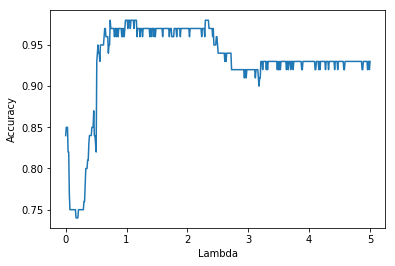

In [15]:
plt.plot(np.linspace(0,max_lambda,N_lambda),accuracy_all)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.show()

In [16]:
import seaborn as sns; 
def heat_map(table,title=""):
    #sns.set()
    ax = sns.heatmap(table)
    ax.set_title(title)

In [17]:

def heat_map2(table,title=""):
    
    plt.pcolor(table)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.axis('equal')
    plt.title(title)
    plt.show()
    
def plot_optimal_state_value(table,title=""):
    
    plt.pcolor(table, cmap=ListedColormap(['white']), edgecolors='black')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    
    for y in range(table.shape[0]):
        for x in range(table.shape[1]):
            if(table[y, x] >= 10):
                plt.text(x + 0.5, y + 0.5, '%.1f' % table[y, x],
                horizontalalignment='center',
                verticalalignment='center', fontsize=7.5)
            else:
                plt.text(x + 0.5, y + 0.5, '%.2f' % table[y, x],
                    horizontalalignment='center',
                    verticalalignment='center', fontsize=7.5)
    plt.show()

def plot_policy_map(table, val, title=""):
    
    plt.pcolor(table, cmap=ListedColormap(['white']), edgecolors='black')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    for y in range(table.shape[0]):
        for x in range(table.shape[1]):
            plt.text(x + 0.5, y + 0.5, val[y, x],
                horizontalalignment='center',
                verticalalignment='center')
    plt.show()
    
def plot_optimal_policy(P,title=""):
    U=np.chararray((P.shape[0], P.shape[1]),unicode=True)
    
    for r in range(P.shape[0]):
        for c in range(P.shape[1]):
           
            if P[r][c] == 0:
                U[r][c] = '\u2191'
           
            elif P[r][c] == 1:
                U[r][c] = '\u2190'
           
            elif P[r][c] == 2:
                U[r][c] = '\u2193'
           
            elif P[r][c] == 3:
                U[r][c] = '\u2192'
    plot_policy_map(P, U, title)

In [35]:
print('\u2192') #u, l, d, r

→


In [18]:
#12
l = np.linspace(0,max_lambda,N_lambda)
a = accuracy_all == np.max(accuracy_all)
#print(np.sort(accuracy_all,-1))

l_max = max(l[a])
print("Best Lambda: %f" % l_max)
print("Best Accuracy: %f" % max(accuracy_all))

Best Lambda: 2.344689
Best Accuracy: 0.980000


In [19]:

estimation_step = 0.01

#D, b = get_LP_components(P,1,4,gamma,random_action_prob)
c = np.concatenate([np.ones((N,)), -l_max*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
x = np.array(sol['x'])
R = np.transpose(np.reshape(x[200:],(10,10)))

v_maxlambda_1, p_maxlambda_1 = get_optimal_val(R, estimation_step, random_action_prob, gamma)
v_truth_1, p_truth_1 = get_optimal_val(reward1, estimation_step, random_action_prob, gamma)

print("Accuracy: %f" % (np.sum(p_truth_1 == p_maxlambda_1)/p_truth_1.size))


Accuracy: 0.980000


Text(0.5, 1.0, 'Reward from IRL')

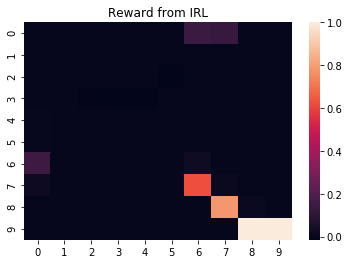

In [20]:
#13
ax = sns.heatmap(R)
ax.set_title("Reward from IRL")

Text(0.5, 1.0, 'Reward 1 from Ground Truth')

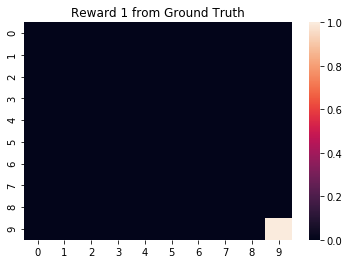

In [21]:
#13
ax = sns.heatmap(reward1)
ax.set_title("Reward 1 from Ground Truth")

Text(0.5, 1.0, 'Optimal state values From Derived Reward')

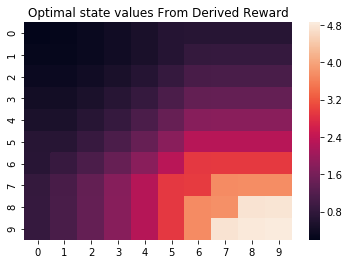

In [22]:
#14
ax = sns.heatmap(v_maxlambda_1)
ax.set_title("Optimal state values From Derived Reward")



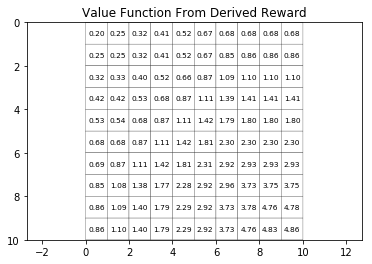

In [23]:
plot_optimal_state_value(v_maxlambda_1, "Value Function From Derived Reward")

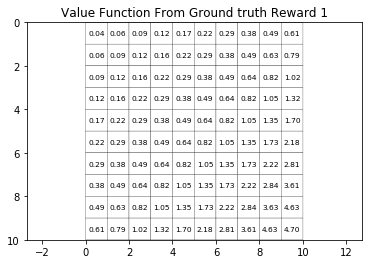

In [24]:
plot_optimal_state_value(v_truth_1, "Value Function From Ground truth Reward 1")

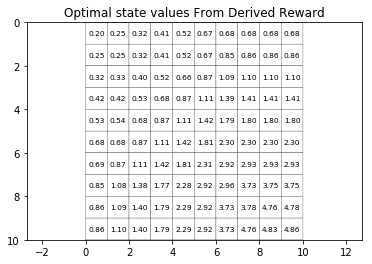

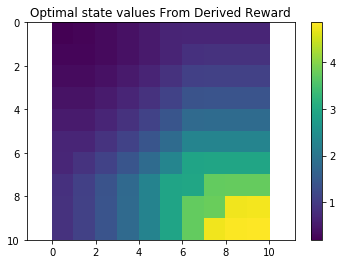

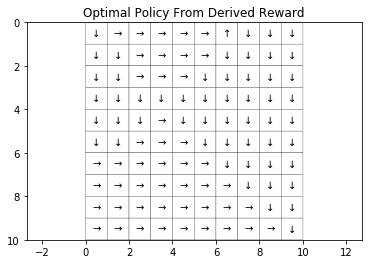

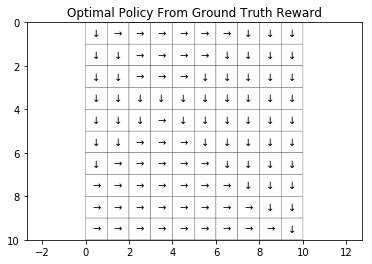

In [25]:
#16
plot_optimal_state_value(v_maxlambda_1, "Optimal state values From Derived Reward")
heat_map2(v_maxlambda_1, "Optimal state values From Derived Reward")


plot_optimal_policy(p_maxlambda_1, "Optimal Policy From Derived Reward")
plot_optimal_policy(p_truth_1, "Optimal Policy From Ground Truth Reward")